# Invariant local feature

画像による物体認識は、ある画像の中に自分の興味のある物体が存在するかどうかを認識するものであり、それをうまく行うことのできる認識器の構築が主な問題となる。認識器は、自身が認識すべき物体が一体どういうものかを予め知っておかなければならなず、我々が認識器にそれを教えるフェーズを学習フェーズと呼ぶ。

SIFT (Scale Invariant Feature Transform) を用いた物体認識の場合、学習フェーズでは、まずは興味ある物体の Keypoints を見つけ出しそれらを説明する descriptors を学習し、それをもとに与えられた画像の中に興味ある物体があるか否かを判断する。Descriptors は keypoints それぞれの周辺の情報を用いて構成されるため、local feature と呼ばれる。

認識フェーズにおいては、与えられた画像の中からその画像にある keypoints を探しだし、それらの descriptors と学習した画像の descriptors の比較を行うことによって認識を行う。

そのため、keypoints とその descriptors にはいくつかの要件がある。そのうちの1つは、画像のスケールの変化に対応できることで、もうひとつは画像の回転に対応できることである。さらに、画像に乗るある程度のノイズや、証明などによる輝度の変化にも対応できなければならない。

SIFT では、keypoints の抽出に scale space を用いることで scale の変化に対応し、また LoG の近似である DoG (Difference of Gaussian) と Harris corder detector に似た手法を用いて回転に対しても対応している。

SIFT における descriptor は、keypoint をその周辺の色情報を用いて説明するものであるが、当然これにも何かしらの工夫を行って上述の要件を満たす必要がある。上述の要件を満たした descriptor を invariant loal feature と呼ぶ。

今回から、SIFT がどのような工夫を行って上述の要件を満たす形で descriptor を表現しているかを学習しながら、実際に Discriptor を構築するプログラムを作成する。

具体的には、大きく分けて下記2ステップを行うこととなるが、今回はステップ1にフォーカスする。

1. Keypoint への orientation の割当
2. 1で作成した orientation をもとに正規化した keypoint 周りの画素の gradients の導出と
   統計情報を加味したフィルタリング

## Orientation (Keypoint の向き)

Orientation は、keypoint 周辺において、どの方向に輝度が最も変化しているかを統計的な情報を加味して表すものである。手順は次のようになる。

### 事前準備

1. 各スケールの画像の各画素における Gradient を計算する。
2. 上記で求めた Gradient の大きさ (magnitude) と、その向き (orientation) を計算する。

### Orientation の計算

1. Orientation を計算する kepoint を選ぶ。
2. Keypoint の属する sclae において、事前準備で求めた Orientation のヒストグラムを作成する。
   ヒストグラムの bin は 10度である。
   また、Orientation をヒストグラムへは、事前準備で求めた magnitude を keypoint の座標を中心とした、
   画像の scale の 1.5 倍の gaussian window でスケールしたものを追加する。
   

# Gradient



Gradient の計算は、次のように行われる。

In [28]:
import numpy as np

def gradient(img, row, col):
    return np.array([img[row + 1, col] - img[row - 1, col], img[row, col + 1] - img[row, col - 1]]) / 2.0

Gradient は対象画素周りの輝度の row 方向の偏微分係数と col 方向の偏微分係数を成分とするベクトルとなっている。画像の輝度がなめらかに変化すると仮定したとき、このベクトルは対象画素周りで輝度が最も変化する方向を指し示す (証明は白版)。

また、上記では偏微分に対象画素の前後の画素を用いて行っているが、これは中心差分近似と呼ばれる手法であり、対象画素とその隣の画素を用いた偏微分よりも精度が良い (証明は白版)。

上の関数を用いれば、画像全体に対する gradient の計算は次のように行うことができる。

1.05 (s)


(-0.5, 511.5, 511.5, -0.5)

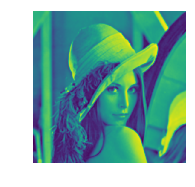

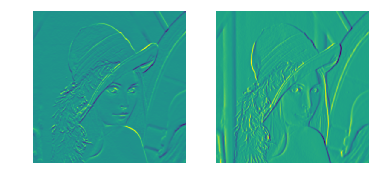

In [142]:
% matplotlib inline

import numpy as np
from scipy.ndimage import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
import time

img = gaussian_filter(imread('img/lenna.png', True), 1.6)
n_rows, n_cols = img.shape

grads_row = np.zeros((n_rows, n_cols))
grads_col = np.zeros((n_rows, n_cols))

start_time = time.time()
for r in range(1, n_rows - 1):
    for c in range(1, n_cols - 1):
        grads_row[r, c], grads_col[r, c] = gradient(img, r, c)
print('{:.2f} (s)'.format(time.time() - start_time))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(grads_row)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grads_col)
plt.axis('off')

上記の方法だと python の for 文を用いたコードを書かなければいけない。せっかく numpy を用いているのにこれでは悲しい。そこで、微分するという作業を画像へのフィルタと考えると、convolution を用いて次のように簡潔に書くことができ、また速度も向上する。

0.02 (s)


(-0.5, 511.5, 511.5, -0.5)

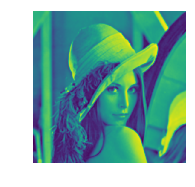

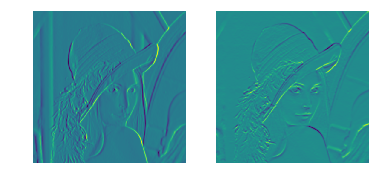

In [143]:
from scipy.signal import convolve2d 

diff_filter = np.array([[-1, 0, 1],])

start_time = time.time()
grads_row = convolve2d(img, diff_filter, boundary='symm', mode='same')
grads_col = convolve2d(img, diff_filter.T, boundary='symm', mode='same')
print('{:.2f} (s)'.format(time.time() - start_time))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(grads_row)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grads_col)
plt.axis('off')

# Magnitude

Magunitude は、Gradient の大きさに関連する。Gradient の大きさは通常次の関数で計算される。

In [144]:
def magnitude(grad):
    return np.sqrt(np.power(grad[0], 2) + np.power(grad[1], 2))

上述の関数を用いて画像の magnitude を求めるには、次のようにすればよい。

1.41 (s)


(-0.5, 511.5, 511.5, -0.5)

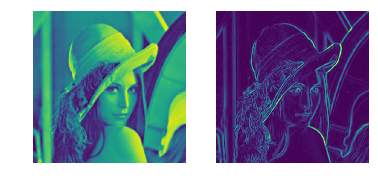

In [145]:
mags = np.zeros(img.shape)

start_time = time.time()
for r in range(n_rows):
    for c in range(n_cols):
        mags[r, c] = magnitude(np.array([grads_row[r, c], grads_col[r, c]]))
print('{:.2f} (s)'.format(time.time() - start_time))
        
        
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mags)
plt.axis('off')

さて、ここでも gradient の時と同様 python の for 文を使ってしまっている。これを numpy を用いたコードに書きなおそうと思えば、次のように書ける。

0.01 (s)


(-0.5, 511.5, 511.5, -0.5)

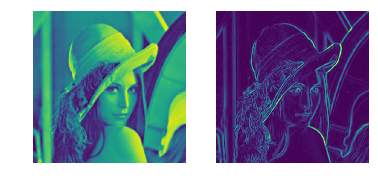

In [146]:
start_time = time.time()
mags = np.sqrt(np.power(grads_row, 2) + np.power(grads_col, 2))
print('{:.2f} (s)'.format(time.time() - start_time))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mags)
plt.axis('off')

# Orientation

ある画素の orientation は、次のようにして計算される。

0.03 (s)


(-0.5, 511.5, 511.5, -0.5)

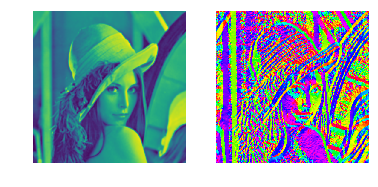

In [147]:
def orientations(grads_row, grads_col):
    thetas = np.nan_to_num(np.arctan2(grads_row, grads_col)) * 180.0 / np.pi
    thetas[thetas < 0] += 360.0
    return thetas

start_time = time.time()
thetas = orientations(grads_row, grads_col)
print('{:.2f} (s)'.format(time.time() - start_time))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thetas, cmap='hsv')
plt.axis('off')

# Gaussian window

ここまでで、事前準備が完了した。ここから keypoint 周りの orientation のヒストグラムの作成に入る。

ヒストグラムの作成には、重み付きカウントを用いる。重みは次の2種類である。

* magnitude
* 対象としている keypoint を中心とする gaussian window

Magnitude を重みに用いるということは、同じ orientation であっても、その magnitude が大きいもののほうが重要なものとして扱われるということである。画像の観点から、magnitude の大きいものは、ノイズや照明の変化に強いと考えられるため、これは妥当である。

対象としている keypoint を中心とする gaussian window を重みとすると、対象としてる keypoint に近いものほど重要なものとして扱われるということである。これを実際に確かめてみる。

Gaussian は次のような関数で定義される。

In [148]:
def gaussian(x, y, sigma):
    return np.exp(-(np.power(x / (2 * sigma), 2) + np.power(y / (2 * sigma), 2))) / (2.0 * np.pi * np.power(sigma, 2))

これを図に示せば、次のようになる。

0.11 (s)
0.08 (s)


(-0.5, 99.5, 99.5, -0.5)

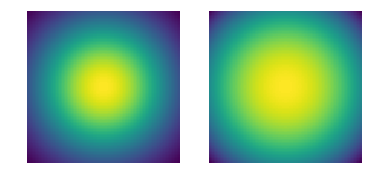

In [149]:
gaussian_window_1 = np.zeros((100, 100))

start_time = time.time()
for r, y in enumerate(np.linspace(-2, 2, 100)):
    for c, x in enumerate(np.linspace(-2, 2, 100)):
        gaussian_window_1[r, c] = gaussian(y, x, 1.0)
print('{:.2f} (s)'.format(time.time() - start_time))

gaussian_window_2 = np.zeros((100, 100))

start_time = time.time()
for r, y in enumerate(np.linspace(-2, 2, 100)):
    for c, x in enumerate(np.linspace(-2, 2, 100)):
        gaussian_window_2[r, c] = gaussian(y, x, 5.0)
print('{:.2f} (s)'.format(time.time() - start_time))
        
        
plt.subplot(1, 2, 1)
plt.imshow(gaussian_window_1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gaussian_window_2)
plt.axis('off')

上図は中心を (0, 0) (配列番号 [50, 50]) とし sigma が 1.0 と 5.0 の時の gaussian の値を (-2.0, 2.0) の区間でプロットしたものである。

これを見ると、中心に近いほど値が大きく、中心から遠ざかるほど小さな値をとることがわかる。また、sigma の値が大きいほど大きな値を取る区間が広くなることもわかる。

Gaussian 関数の計算は計算コストが高いため、画像全体に対してそれを適用するのは望ましくないが、上図を見れば sigma に応じてウィンドを設計し、そのウィンドウの範囲のみ計算してやれば良さそうである。そのウィンドウを gaussian window と呼ぶ。

Gaussian window は上記のコードに少し変更を加えることで作成可能であるが、これも python の for 文を用いてしまっている。 for 文を用いずに書くには次のようにすれば良い。 

0.00 (s)
0.00 (s)


(-0.5, 10.5, 10.5, -0.5)

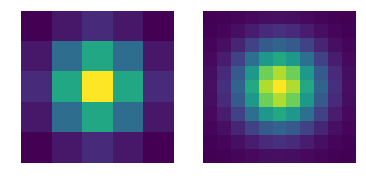

In [150]:
def gaussian_window(sigma, size):
    assert size % 2 != 0
    x, y = np.meshgrid(np.arange(-int(size / 2), int(size / 2) + 1), 
                       np.arange(-int(size / 2), int(size / 2) + 1))
    w = np.exp(-(np.power(x, 2) + np.power(y, 2)) / (2.0 * np.power(sigma, 2)))
    return w / np.sum(w)

start_time = time.time()
gaussian_window_1 = gaussian_window(1.0, 5)
print('{:.2f} (s)'.format(time.time() - start_time))


start_time = time.time()
gaussian_window_2 = gaussian_window(2.0, 11)
print('{:.2f} (s)'.format(time.time() - start_time))


plt.subplot(1, 2, 1)
plt.imshow(gaussian_window_1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gaussian_window_2)
plt.axis('off')

## Histogram

ある点周りのヒストグラムの作成を行う。

Keypoint の位置を (row, col), gaussian window のサイズを size として、ヒストグラムを作成する。orientation の画像と magnitude の画像を使えば、次のようにプログラムを書くことができる。

0.00 (s)


<Container object of 36 artists>

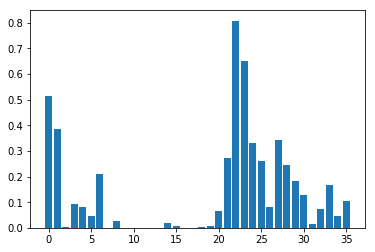

In [165]:
import copy

def orientation_hist(magnitudes, orientations, row, col, sigma, size):
    gw = gaussian_window(sigma, size)
    magnitudes = (magnitudes[row:row + size, col:col + size] * gw).flatten()
    orientations = orientations[row:row + size, col:col + size].flatten()

    bins = np.zeros((36, ))
    for i , o in enumerate(orientations):
        bins[int(o / 10)] += magnitudes[i]
        
    return bins

start_time = time.time()
hist = orientation_hist(mags, thetas, 150, 150, 1.6 * 1.5, 17)
print('{:.2f} (s)'.format(time.time() - start_time))

plt.bar(np.arange(36), hist)

## Orientation Assignment

最後に、作成したヒストグラムを基に、keypoint に対して orientation を割り当てる。

Keypoint の orientation としてヒストグラムで最も値の高い値の 80% 以上の値を持つものが割り当てられる。もしも、該当するものが複数ある場合には、その場所に複数の keypoints が存在すると考える。

下記に keypoint への orientation 割り当てのコードを示す。

In [167]:
def keypoint_orientations(hist):
    return np.where(hist >= np.max(hist) * 0.8)[0] * 10

kpt_oris = keypoint_orientations(hist)

print(kpt_oris)

[220 230]
